#**Motor Imagery EEG Signal Analysis for Finger Movement: An Approach to Brain-Computer Interfaces**

---
`In this study, we aimed to classify finger movements using brain signals captured through EEG. We focused on five distinct classes of finger movements: Thumb, Index, Middle, Ring, and Pinky. Utilizing Convolutional Neural Networks (CNN) for spatial feature extraction from EEG data, we reduced the complexity by using only 4 channels out of the original 64. This reduction was achieved before applying Continuous Wavelet Transform (CWT) analysis with the Morlet mother wavelet and a scale of 10
`



In [ ]:
# Eng/Amr Mostafa Omar
# Nile University ,Cairo, Egypt
# Data 20/6/2024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.6 MB/s eta 0:00:00


In [ ]:
import scipy.io
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pywt
import gc
import psutil
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

##**Step 1: Load Data**

In [ ]:
# Step 1: Loading Data
def load_data_from_mat(mat_file_path):
    mat_data = scipy.io.loadmat(mat_file_path)
    data = mat_data['Data'][0, 0]
    X = data['trials']  # EEG data (256, 64, 900)
    y = data['Labels'].flatten()  # Target labels (900,)
    Fs = data['Fs'][0, 0]  # Sampling frequency
    Channels = [ch[0] for ch in data['Channels'][0]]  # EEG channels
    return X, y, Fs, Channels

# List of file paths
mat_file_paths = [
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_1.mat',
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_2.mat',
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_3.mat',
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_4.mat',
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_5.mat'
]

X_all = []
Y_all = []

for mat_file_path in mat_file_paths:
    X, y, Fs, Channels = load_data_from_mat(mat_file_path)
    X_all.append(X)
    Y_all.append(y)

X = np.concatenate(X_all, axis=2)
y = np.concatenate(Y_all)

print("Combined EEG Data Shape (Trials):", X.shape)
print("Combined Labels Shape:", y.shape)
print("Sampling Frequency:", Fs)
print("Channels:", Channels)


Combined EEG Data Shape (Trials): (256, 64, 4542)
Combined Labels Shape: (4542,)
Sampling Frequency: 256
Channels: ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'TP9', 'TP10', 'FT9', 'FT10']


##**Step 2: Preprocess Data**

In [ ]:
# Preprocessing
lowcut = 8.0
highcut = 30.0
order = 5

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

filtered_data = np.zeros_like(X)
for trial in range(X.shape[2]):
    for channel in range(X.shape[1]):
        filtered_data[:, channel, trial] = bandpass_filter(X[:, channel, trial], lowcut, highcut, Fs, order=order)

mean_signal = np.mean(filtered_data, axis=1, keepdims=True)
filtered_data -= mean_signal

selected_channels = ['T7',  'TP7','PO3',  'PO7']
channel_indices = [Channels.index(ch) for ch in selected_channels]
filtered_data_selected = filtered_data[:, channel_indices, :]

print("Filtered and CAR Processed Data Shape (Selected Channels):", filtered_data_selected.shape)

reshaped_data = filtered_data_selected.reshape(-1, filtered_data_selected.shape[1])
scaler = RobustScaler()
scaled_data = scaler.fit_transform(reshaped_data)
scaled_data_3d = scaled_data.reshape(filtered_data_selected.shape)

print("Scaled Data Shape (Selected Channels):", scaled_data_3d.shape)


Filtered and CAR Processed Data Shape (Selected Channels): (256, 4, 4542)
Scaled Data Shape (Selected Channels): (256, 4, 4542)


##**Step 3: Split Data into Classes**

In [ ]:
def assign_data_to_class(class_label, scaled_data_3d, y, percentage=0.25):
    target_trials = scaled_data_3d[:, :, y == class_label]
    num_target_trials = target_trials.shape[2]

    num_non_target_trials_per_class = int(percentage * num_target_trials)
    non_target_trials = []
    for other_class_label in range(1, 6):
        if other_class_label != class_label:
            other_class_trials = scaled_data_3d[:, :, y == other_class_label]
            non_target_trials.append(other_class_trials[:, :, :num_non_target_trials_per_class])
    non_target_trials = np.concatenate(non_target_trials, axis=2)

    combined_trials = np.concatenate((target_trials, non_target_trials), axis=2)
    combined_labels = np.array([1] * num_target_trials + [0] * non_target_trials.shape[2])
    return combined_trials, combined_labels

X_thumb, Y_thumb = assign_data_to_class(1, scaled_data_3d, y)
X_index, Y_index = assign_data_to_class(2, scaled_data_3d, y)
X_middle, Y_middle = assign_data_to_class(3, scaled_data_3d, y)
X_ring, Y_ring = assign_data_to_class(4, scaled_data_3d, y)
X_pinky, Y_pinky = assign_data_to_class(5, scaled_data_3d, y)

print("Thumb Data Shape (Trials):", X_thumb.shape, "Labels Shape:", Y_thumb.shape)
print("Index Data Shape (Trials):", X_index.shape, "Labels Shape:", Y_index.shape)
print("Middle Data Shape (Trials):", X_middle.shape, "Labels Shape:", Y_middle.shape)
print("Ring Data Shape (Trials):", X_ring.shape, "Labels Shape:", Y_ring.shape)
print("Pinky Data Shape (Trials):", X_pinky.shape, "Labels Shape:", Y_pinky.shape)


Thumb Data Shape (Trials): (256, 4, 1810) Labels Shape: (1810,)
Index Data Shape (Trials): (256, 4, 1817) Labels Shape: (1817,)
Middle Data Shape (Trials): (256, 4, 1817) Labels Shape: (1817,)
Ring Data Shape (Trials): (256, 4, 1817) Labels Shape: (1817,)
Pinky Data Shape (Trials): (256, 4, 1817) Labels Shape: (1817,)


##**Step 4: Split Data into Training and Testing Sets**

In [ ]:
def split_data(trials, labels):
    train_trials, test_trials, train_labels, test_labels = train_test_split(
        trials.transpose(2, 0, 1), labels, test_size=0.2, random_state=42, stratify=labels)
    train_trials = train_trials.transpose(1, 2, 0)
    test_trials = test_trials.transpose(1, 2, 0)
    return train_trials, test_trials, train_labels, test_labels

X_train_thumb, X_test_thumb, Y_train_thumb, Y_test_thumb = split_data(X_thumb, Y_thumb)
X_train_index, X_test_index, Y_train_index, Y_test_index = split_data(X_index, Y_index)
X_train_middle, X_test_middle, Y_train_middle, Y_test_middle = split_data(X_middle, Y_middle)
X_train_ring, X_test_ring, Y_train_ring, Y_test_ring = split_data(X_ring, Y_ring)
X_train_pinky, X_test_pinky, Y_train_pinky, Y_test_pinky = split_data(X_pinky, Y_pinky)

print("Thumb Train Data Shape (Trials):", X_train_thumb.shape, "Train Labels Shape:", Y_train_thumb.shape)
print("Thumb Test Data Shape (Trials):", X_test_thumb.shape, "Test Labels Shape:", Y_test_thumb.shape)
print("Index Train Data Shape (Trials):", X_train_index.shape, "Train Labels Shape:", Y_train_index.shape)
print("Index Test Data Shape (Trials):", X_test_index.shape, "Test Labels Shape:", Y_test_index.shape)
print("Middle Train Data Shape (Trials):", X_train_middle.shape, "Train Labels Shape:", Y_train_middle.shape)
print("Middle Test Data Shape (Trials):", X_test_middle.shape, "Test Labels Shape:", Y_test_middle.shape)
print("Ring Train Data Shape (Trials):", X_train_ring.shape, "Train Labels Shape:", Y_train_ring.shape)
print("Ring Test Data Shape (Trials):", X_test_ring.shape, "Test Labels Shape:", Y_test_ring.shape)
print("Pinky Train Data Shape (Trials):", X_train_pinky.shape, "Train Labels Shape:", Y_train_pinky.shape)
print("Pinky Test Data Shape (Trials):", X_test_pinky.shape, "Test Labels Shape:", Y_test_pinky.shape)


Thumb Train Data Shape (Trials): (256, 4, 1448) Train Labels Shape: (1448,)
Thumb Test Data Shape (Trials): (256, 4, 362) Test Labels Shape: (362,)
Index Train Data Shape (Trials): (256, 4, 1453) Train Labels Shape: (1453,)
Index Test Data Shape (Trials): (256, 4, 364) Test Labels Shape: (364,)
Middle Train Data Shape (Trials): (256, 4, 1453) Train Labels Shape: (1453,)
Middle Test Data Shape (Trials): (256, 4, 364) Test Labels Shape: (364,)
Ring Train Data Shape (Trials): (256, 4, 1453) Train Labels Shape: (1453,)
Ring Test Data Shape (Trials): (256, 4, 364) Test Labels Shape: (364,)
Pinky Train Data Shape (Trials): (256, 4, 1453) Train Labels Shape: (1453,)
Pinky Test Data Shape (Trials): (256, 4, 364) Test Labels Shape: (364,)


##**Step 5: Apply Continuous Wavelet Transform (CWT)**

In [ ]:
def apply_cwt(data):
    scales = np.arange(1, 101)  # scales from 1 to 100
    cwt_coeffs = []
    for trial in data.transpose(2, 1, 0):  # Transpose to (trials, channels, samples)
        trial_coeffs = []
        for channel in trial:
            coeffs, freqs = pywt.cwt(channel, scales, 'morl')  # wavelet 'morl'
            trial_coeffs.append(coeffs)
        cwt_coeffs.append(trial_coeffs)
    cwt_coeffs = np.array(cwt_coeffs)
    # Transpose to get shape (trials, samples, coefficients, channels)
    cwt_coeffs = cwt_coeffs.transpose(0, 2, 3, 1)
    return cwt_coeffs

##**Step 6: Train and Evaluate CNN Model**

In [ ]:
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")

def clear_memory():
    gc.collect()
    print_memory_usage()

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_memory()

# Define your datasets
datasets = {
    "thumb": (X_train_thumb, X_test_thumb, Y_train_thumb, Y_test_thumb),
    "index": (X_train_index, X_test_index, Y_train_index, Y_test_index),
    "middle": (X_train_middle, X_test_middle, Y_train_middle, Y_test_middle),
    "ring": (X_train_ring, X_test_ring, Y_train_ring, Y_test_ring),
    "pinky": (X_train_pinky, X_test_pinky, Y_train_pinky, Y_test_pinky)
}

results = {}

thumb Train CWT Data Shape: (1448, 100, 256, 4)
thumb Test CWT Data Shape: (362, 100, 256, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 252, 64)       6464      
                                                                 
 batch_normalization (Batch  (None, 96, 252, 64)       256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 126, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 124, 128)      73856     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 124, 128)      512       
 chNormalization)           

37/37 [==============================] - 9s 124ms/step - loss: 7.0536 - accuracy: 0.5328 - val_loss: 2.3558 - val_accuracy: 0.4621
Epoch 2/20
37/37 [==============================] - 3s 89ms/step - loss: 0.7181 - accuracy: 0.5225 - val_loss: 0.7527 - val_accuracy: 0.4483
Epoch 3/20
37/37 [==============================] - 3s 79ms/step - loss: 0.6741 - accuracy: 0.5354 - val_loss: 0.7681 - val_accuracy: 0.5621
Epoch 4/20
37/37 [==============================] - 3s 79ms/step - loss: 0.6366 - accuracy: 0.6295 - val_loss: 0.7011 - val_accuracy: 0.6103
Epoch 5/20
37/37 [==============================] - 3s 84ms/step - loss: 0.6017 - accuracy: 0.6969 - val_loss: 0.6789 - val_accuracy: 0.6690
Epoch 6/20
37/37 [==============================] - 3s 85ms/step - loss: 0.6142 - accuracy: 0.7012 - val_loss: 0.6468 - val_accuracy: 0.6276
Epoch 7/20
37/37 [==============================] - 3s 82ms/step - loss: 0.5360 - accuracy: 0.7478 - val_loss: 0.6379 - val_accuracy: 0.7172
Epoch 8/20
37/37 [=====

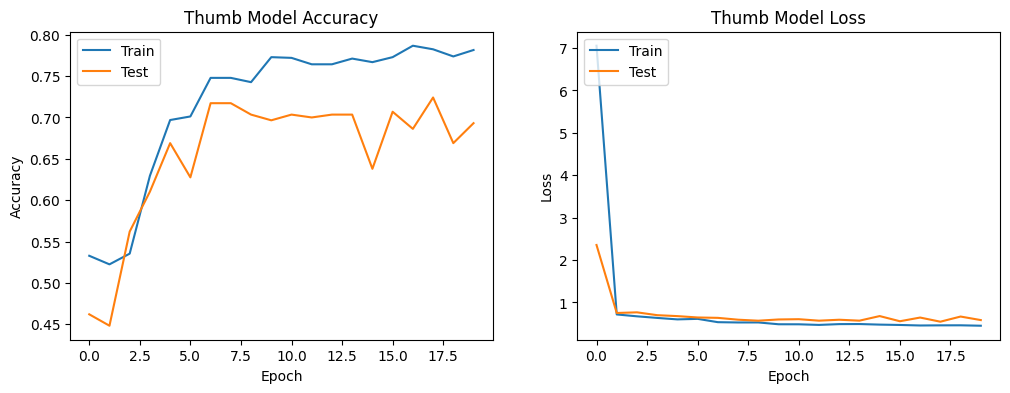

12/12 [==============================] - 0s 17ms/step


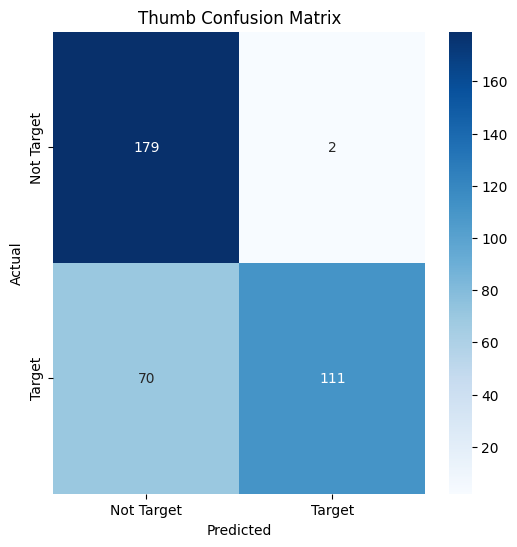

Thumb Classification Report:
              precision    recall  f1-score   support

  Not Target       0.72      0.99      0.83       181
      Target       0.98      0.61      0.76       181

    accuracy                           0.80       362
   macro avg       0.85      0.80      0.79       362
weighted avg       0.85      0.80      0.79       362

index Train CWT Data Shape: (1453, 100, 256, 4)
index Test CWT Data Shape: (364, 100, 256, 4)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 252, 64)       6464      
                                                                 
 batch_normalization_2 (Bat  (None, 96, 252, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 126, 64)       0         


37/37 [==============================] - 6s 124ms/step - loss: 13.5867 - accuracy: 0.6033 - val_loss: 8.7426 - val_accuracy: 0.4777
Epoch 2/20
37/37 [==============================] - 3s 83ms/step - loss: 1.0385 - accuracy: 0.5990 - val_loss: 1.4766 - val_accuracy: 0.5636
Epoch 3/20
37/37 [==============================] - 3s 79ms/step - loss: 0.7035 - accuracy: 0.6429 - val_loss: 1.0495 - val_accuracy: 0.6564
Epoch 4/20
37/37 [==============================] - 3s 80ms/step - loss: 0.6205 - accuracy: 0.6893 - val_loss: 1.3125 - val_accuracy: 0.6632
Epoch 5/20
37/37 [==============================] - 3s 80ms/step - loss: 0.6626 - accuracy: 0.7048 - val_loss: 0.7354 - val_accuracy: 0.7148
Epoch 6/20
37/37 [==============================] - 3s 89ms/step - loss: 0.5797 - accuracy: 0.7126 - val_loss: 0.7460 - val_accuracy: 0.6873
Epoch 7/20
37/37 [==============================] - 3s 84ms/step - loss: 0.5580 - accuracy: 0.7341 - val_loss: 0.7170 - val_accuracy: 0.7388
Epoch 8/20
37/37 [====

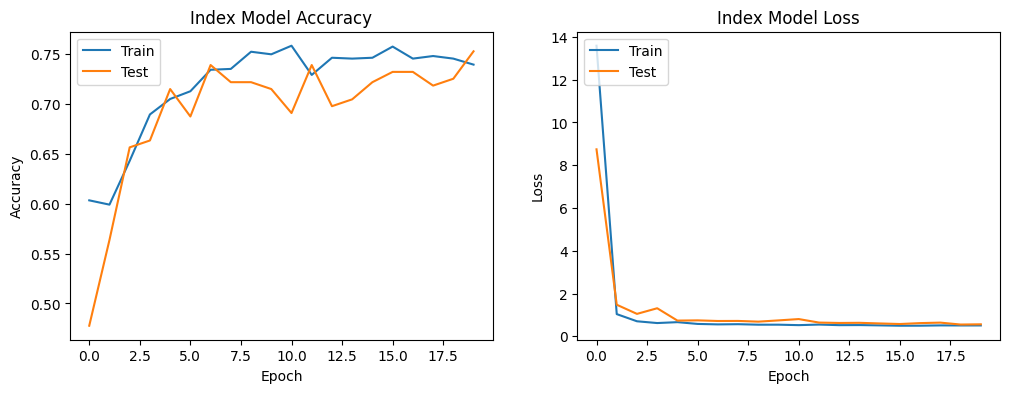

12/12 [==============================] - 0s 17ms/step


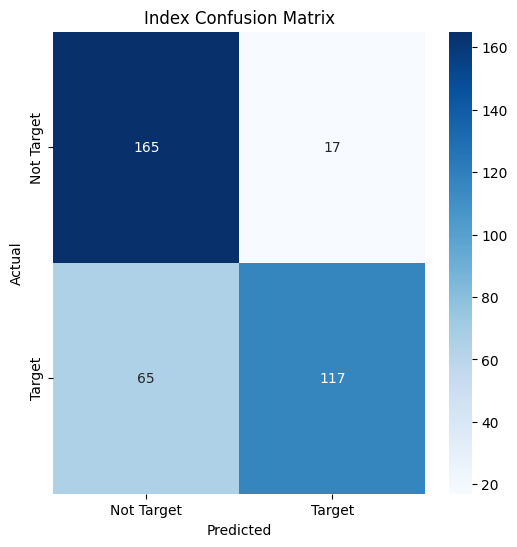

Index Classification Report:
              precision    recall  f1-score   support

  Not Target       0.72      0.91      0.80       182
      Target       0.87      0.64      0.74       182

    accuracy                           0.77       364
   macro avg       0.80      0.77      0.77       364
weighted avg       0.80      0.77      0.77       364

middle Train CWT Data Shape: (1453, 100, 256, 4)
middle Test CWT Data Shape: (364, 100, 256, 4)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 252, 64)       6464      
                                                                 
 batch_normalization_4 (Bat  (None, 96, 252, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 126, 64)       0        

37/37 [==============================] - 6s 102ms/step - loss: 7.5261 - accuracy: 0.5336 - val_loss: 3.1322 - val_accuracy: 0.4742
Epoch 2/20
37/37 [==============================] - 3s 84ms/step - loss: 0.7523 - accuracy: 0.6239 - val_loss: 1.1700 - val_accuracy: 0.5258
Epoch 3/20
37/37 [==============================] - 3s 85ms/step - loss: 0.6546 - accuracy: 0.6773 - val_loss: 1.3748 - val_accuracy: 0.5395
Epoch 4/20
37/37 [==============================] - 3s 92ms/step - loss: 0.6313 - accuracy: 0.7160 - val_loss: 0.7237 - val_accuracy: 0.6770
Epoch 5/20
37/37 [==============================] - 3s 81ms/step - loss: 0.6051 - accuracy: 0.7160 - val_loss: 0.6985 - val_accuracy: 0.6907
Epoch 6/20
37/37 [==============================] - 3s 84ms/step - loss: 0.5825 - accuracy: 0.7238 - val_loss: 0.6713 - val_accuracy: 0.7182
Epoch 7/20
37/37 [==============================] - 3s 88ms/step - loss: 0.5871 - accuracy: 0.7117 - val_loss: 0.6310 - val_accuracy: 0.7285
Epoch 8/20
37/37 [=====

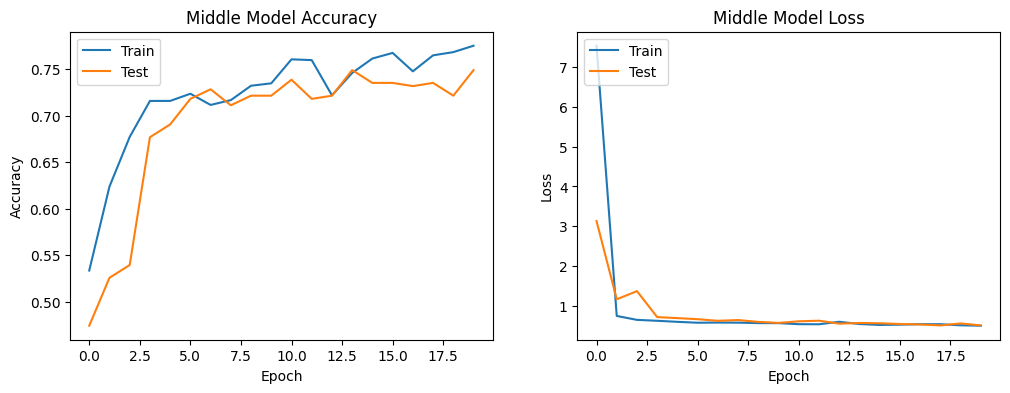

12/12 [==============================] - 0s 18ms/step


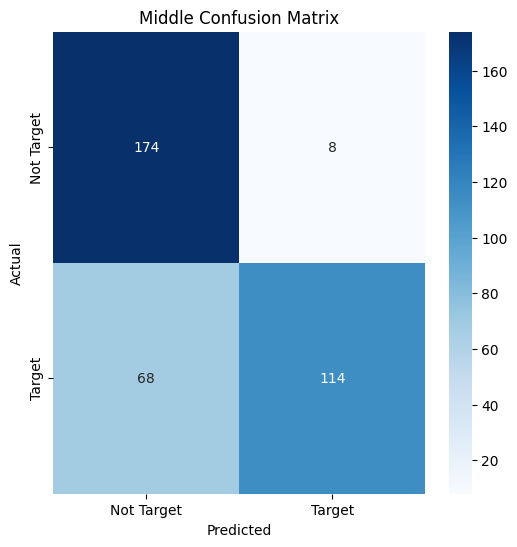

Middle Classification Report:
              precision    recall  f1-score   support

  Not Target       0.72      0.96      0.82       182
      Target       0.93      0.63      0.75       182

    accuracy                           0.79       364
   macro avg       0.83      0.79      0.79       364
weighted avg       0.83      0.79      0.79       364

ring Train CWT Data Shape: (1453, 100, 256, 4)
ring Test CWT Data Shape: (364, 100, 256, 4)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 96, 252, 64)       6464      
                                                                 
 batch_normalization_6 (Bat  (None, 96, 252, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 126, 64)       0         
 

37/37 [==============================] - 6s 103ms/step - loss: 12.2098 - accuracy: 0.5465 - val_loss: 1.9670 - val_accuracy: 0.4777
Epoch 2/20
37/37 [==============================] - 3s 81ms/step - loss: 0.7005 - accuracy: 0.5972 - val_loss: 0.6868 - val_accuracy: 0.5533
Epoch 3/20
37/37 [==============================] - 3s 82ms/step - loss: 0.6737 - accuracy: 0.6515 - val_loss: 0.6195 - val_accuracy: 0.6495
Epoch 4/20
37/37 [==============================] - 3s 92ms/step - loss: 0.6067 - accuracy: 0.7117 - val_loss: 0.6002 - val_accuracy: 0.6873
Epoch 5/20
37/37 [==============================] - 3s 86ms/step - loss: 0.5996 - accuracy: 0.7022 - val_loss: 0.6030 - val_accuracy: 0.7320
Epoch 6/20
37/37 [==============================] - 3s 82ms/step - loss: 0.5845 - accuracy: 0.7160 - val_loss: 0.5797 - val_accuracy: 0.7045
Epoch 7/20
37/37 [==============================] - 3s 85ms/step - loss: 0.5944 - accuracy: 0.7151 - val_loss: 0.5918 - val_accuracy: 0.6873
Epoch 8/20
37/37 [====

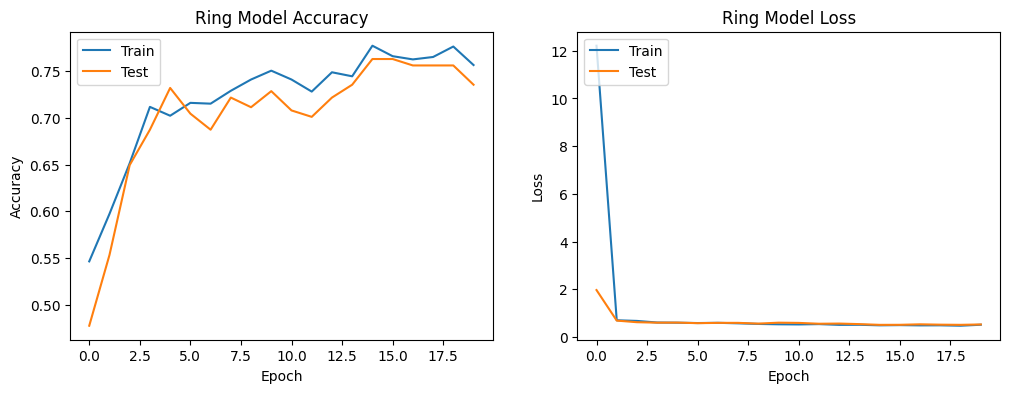

12/12 [==============================] - 0s 20ms/step


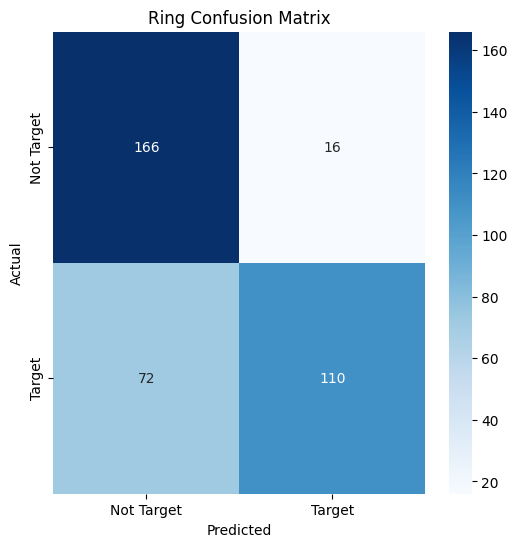

Ring Classification Report:
              precision    recall  f1-score   support

  Not Target       0.70      0.91      0.79       182
      Target       0.87      0.60      0.71       182

    accuracy                           0.76       364
   macro avg       0.79      0.76      0.75       364
weighted avg       0.79      0.76      0.75       364

pinky Train CWT Data Shape: (1453, 100, 256, 4)
pinky Test CWT Data Shape: (364, 100, 256, 4)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 252, 64)       6464      
                                                                 
 batch_normalization_8 (Bat  (None, 96, 252, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 48, 126, 64)       0         
 

37/37 [==============================] - 6s 109ms/step - loss: 6.0990 - accuracy: 0.5697 - val_loss: 1.7266 - val_accuracy: 0.4742
Epoch 2/20
37/37 [==============================] - 3s 84ms/step - loss: 0.6866 - accuracy: 0.6093 - val_loss: 1.0320 - val_accuracy: 0.5739
Epoch 3/20
37/37 [==============================] - 3s 81ms/step - loss: 0.6647 - accuracy: 0.6583 - val_loss: 0.8392 - val_accuracy: 0.6186
Epoch 4/20
37/37 [==============================] - 3s 82ms/step - loss: 0.6390 - accuracy: 0.7014 - val_loss: 0.6824 - val_accuracy: 0.6735
Epoch 5/20
37/37 [==============================] - 3s 87ms/step - loss: 0.6135 - accuracy: 0.7169 - val_loss: 0.6409 - val_accuracy: 0.6667
Epoch 6/20
37/37 [==============================] - 3s 88ms/step - loss: 0.5896 - accuracy: 0.7298 - val_loss: 0.5929 - val_accuracy: 0.6770
Epoch 7/20
37/37 [==============================] - 3s 82ms/step - loss: 0.6034 - accuracy: 0.7522 - val_loss: 0.5889 - val_accuracy: 0.7148
Epoch 8/20
37/37 [=====

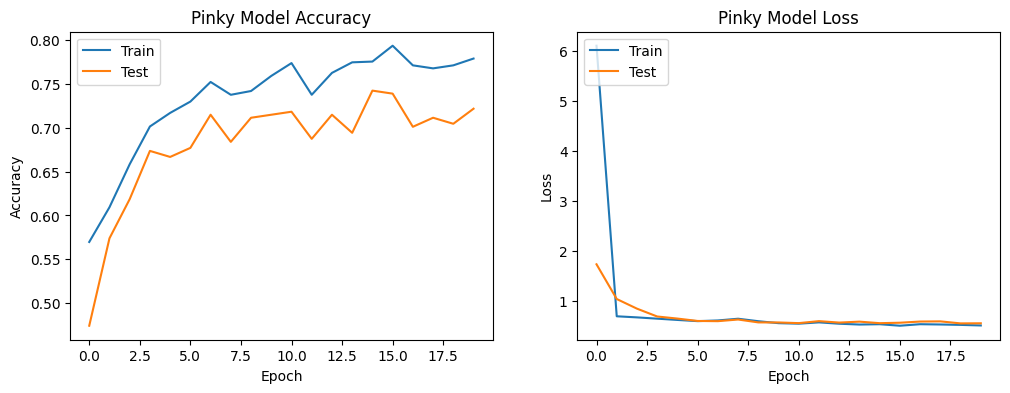

12/12 [==============================] - 0s 23ms/step


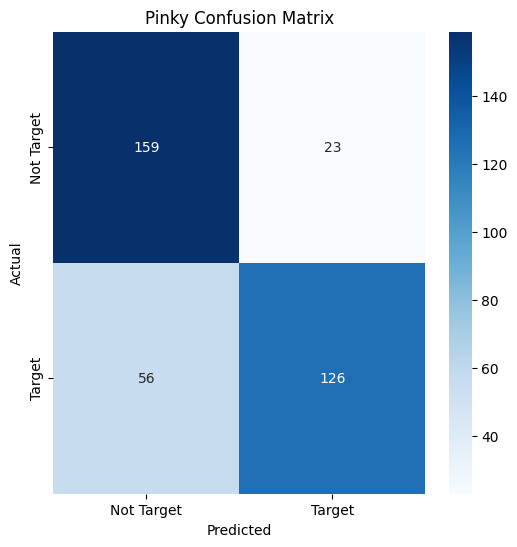

Pinky Classification Report:
              precision    recall  f1-score   support

  Not Target       0.74      0.87      0.80       182
      Target       0.85      0.69      0.76       182

    accuracy                           0.78       364
   macro avg       0.79      0.78      0.78       364
weighted avg       0.79      0.78      0.78       364

Final accuracies:
thumb: 0.8011
index: 0.7747
middle: 0.7912
ring: 0.7582
pinky: 0.7830


In [ ]:
for finger, (X_train, X_test, Y_train, Y_test) in datasets.items():
    # Apply CWT to the data
    X_train_cwt = apply_cwt(X_train)
    X_test_cwt = apply_cwt(X_test)

    print(f"{finger} Train CWT Data Shape:", X_train_cwt.shape)
    print(f"{finger} Test CWT Data Shape:", X_test_cwt.shape)

    model = Sequential([
        Conv2D(64, (5, 5), activation='relu', input_shape=(100,256, 4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(X_train_cwt, Y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[ClearMemory()])

    # Evaluate model
    loss, accuracy = model.evaluate(X_test_cwt, Y_test)
    results[finger] = accuracy
    print(f"Accuracy for {finger}: {accuracy:.4f}")

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{finger.capitalize()} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{finger.capitalize()} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    # Predict the values from the test set
    Y_pred = (model.predict(X_test_cwt) > 0.5).astype("int32")

    # Confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Target', 'Target'], yticklabels=['Not Target', 'Target'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{finger.capitalize()} Confusion Matrix')
    plt.show()

    # Classification report
    print(f'{finger.capitalize()} Classification Report:')
    print(classification_report(Y_test, Y_pred, target_names=['Not Target', 'Target']))

    del X_train_cwt, X_test_cwt

# Print final accuracies
print("Final accuracies:")
for finger, accuracy in results.items():
    print(f"{finger}: {accuracy:.4f}")